In [25]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text


In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents


In [5]:
data = read_text("deu-eng/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [10]:
deu_eng[100]

array(['Be kind.', 'Sei nett!',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #1916315 (CK) & #1998565 (Tamy)'],
      dtype='<U537')

In [7]:

deu_eng = deu_eng[:50000,:]

In [11]:
'''Text Pre-Processing'''
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
'''Text to Sequence Conversion'''

eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

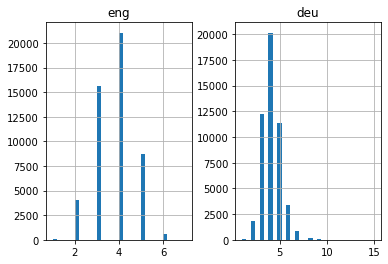

In [14]:
length_df.hist(bins = 30)
plt.show()

In [26]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# preparing english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# preparing Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

English Vocabulary Size: 6243
Deutch Vocabulary Size: 10329


In [27]:
'''Padding'''
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [28]:
'''Model Building'''
from sklearn.model_selection import train_test_split
#splitting 
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)


In [29]:
print(len(train))
print(len(test))

40000
10000


In [30]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])


In [31]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [32]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [33]:
'''optimizer '''
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
# 'sparse_categorical_crossentropy' as the loss function allows us to use the target sequence as it is instead of one hot encoded format.

In [34]:
filename = 'MTmodel.h1.24_Aug_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4173
Epoch 00001: val_loss improved from inf to 2.89507, saving model to MTmodel.h1.24_Aug_20
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: MTmodel.h1.24_Aug_20/assets
63/63 [==============================] - 127s 2s/step - loss: 3.4173 - val_loss: 2.8951
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7831
Epoch 00002: val_loss improved from 2.89507 to 2.82129, saving model to MTmodel.h1.24_Aug_20
INFO:tensorflow:Assets written to: MTmodel.h1.24_Aug_20/assets
63/63 [==============================] - 120s 2s/step - loss: 2.7831 - val_loss: 2.8213
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.6311
Epoch 00003: val_loss improved from 2.82129 to 2.57989, s